# Quora Insincere Questions Classification - Deep Learning & Neural Networks

1. Download the dataset from Kaggle: https://www.kaggle.com/c/quora-insincere-questions-classification/data
2. Prepare the data for modeling using TF-IDF
3. Train a deep learning model using PyTorch


## Download the dataset


In [135]:
import os

In [136]:
IS_KAGGLE = "KAGGLE_KERNEL_RUN_TYPE" in os.environ
DATA_DIR = (
    "/kaggle/input/quora-insincere-questions -classification"
    if IS_KAGGLE
    else "../data/quora-insincere-questions-classification"
)

In [137]:
if not IS_KAGGLE:
	!kaggle competitions download -c quora-insincere-questions-classification -f train.csv -p ../data/quora-insincere-questions-classification
	!kaggle competitions download -c quora-insincere-questions-classification -f test.csv -p ../data/quora-insincere-questions-classification
	!kaggle competitions download -c quora-insincere-questions-classification -f sample_submission.csv -p ../data/quora-insincere-questions-classification

50310.65s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


50318.99s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


50325.89s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [138]:
train_fname = DATA_DIR + "/train.csv.zip"
test_fname = DATA_DIR + "/test.csv.zip"
sub_fname = DATA_DIR + "/sample_submission.csv.zip"

In [139]:
import pandas as pd

In [140]:
raw_df = pd.read_csv(train_fname)
test_df = pd.read_csv(test_fname)
sub_df = pd.read_csv(sub_fname)

In [141]:
raw_df.sample(5)

,qid,question_text,target
19659,03d9a7cafc0f29d20b4c,What is the triple point? I know the definitio...,0
530032,67c6c022d8fcec6a8ea5,What are the best blog builder sites with free...,0
791671,9b206a92edbf814590f3,What charges could be imposed on Smith Warner ...,0
785732,99ecb52f63798b43258a,Is there a Torso length reduction surgery?,0
325889,3fe05fa90bab7b30d95d,I got 61663 rank in EAMCET where would I get a...,0


In [142]:
raw_df.target.value_counts()

target
0    1225312
1      80810
Name: count, dtype: int64

In [143]:
test_df.sample(5)

,qid,question_text
360158,f576644514ab03dcfd25,What problem could image recognition solves?
325590,ddb3b33c49d90c723275,"What are good places to eat in Yau Ma Tei, Hon..."
13576,094665f95da48640b510,Is sleeping near the mobile phone even it is o...
106480,485fe7e35bf5c7185d9d,How can I become more resilient?
4196,02d732d2964195200186,How do you able to deliver so eloquently the s...


In [144]:
sub_df.sample(5)

,qid,prediction
322432,db983ff0251695d522a3,0
264529,b42f83a08cd59fddc38c,0
217299,93e7e39a77c793889a6a,0
21791,0ec83dee23ad2c952593,0
144757,6291751c823ec09201f1,0


In [145]:
SAMPLE_SIZE = 100_000
sample_df = raw_df.sample(SAMPLE_SIZE, random_state=42)
sample_df

,qid,question_text,target
443046,56d324bb1e2c29f43b12,What is the most effective classroom managemen...,0
947549,b9ad893dc78c577f8a63,Can I study abroad after 10th class from Bangl...,0
523769,6689ebaeeb65b209a412,How can I make friends as a college junior?,0
949821,ba1e2c4a0fef09671516,How do I download free APK Minecraft: Pocket E...,0
1030397,c9ea2b69bf0d74626f46,"Like Kuvera, is ""Groww"" also a free online inv...",0
...,...,...,...
998930,c3c03a307a29c69971b4,How do I research list of reliable charcoal im...,0
66641,0d119aba95ee6684f506,"What are petroleum products, and what is petro...",0
90024,11a46cd148a104b271cf,What are some services that will let you quick...,0
130113,1973e6e2111a0c93193a,What credit card processors do online marketpl...,0


In [146]:
sample_df.target.value_counts(normalize=True)

target
0    0.93962
1    0.06038
Name: proportion, dtype: float64

## Prepare Data for Training

-   Convert the text data into TF-IDF vectors
-   Convert vectors to PyTorch tensors
-   Create a PyTorch dataset and dataloader


### Convert text data into TF-IDF vectors


In [147]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/macbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [148]:
eng_stopwords = stopwords.words("english")

In [149]:
stemmer = SnowballStemmer(language="english")

In [150]:
def tokenize(text):
    return [stemmer.stem(token) for token in word_tokenize(text.lower())]

In [151]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [152]:
vectorizer = TfidfVectorizer(
    tokenizer=tokenize, stop_words=eng_stopwords, ngram_range=(1, 2), max_features=1000
)

In [153]:
sample_df.question_text

443046     What is the most effective classroom managemen...
947549     Can I study abroad after 10th class from Bangl...
523769           How can I make friends as a college junior?
949821     How do I download free APK Minecraft: Pocket E...
1030397    Like Kuvera, is "Groww" also a free online inv...
                                 ...                        
998930     How do I research list of reliable charcoal im...
66641      What are petroleum products, and what is petro...
90024      What are some services that will let you quick...
130113     What credit card processors do online marketpl...
1137            On which number system does a computer work?
Name: question_text, Length: 100000, dtype: object

In [154]:
vectorizer.fit(sample_df.question_text)

/Users/macbook/.local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/macbook/.local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


TfidfVectorizer(max_features=1000, ngram_range=(1, 2),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x340d5ca40>)

In [155]:
vectorizer.get_feature_names_out()[:100]

array(['!', '$', '%', '&', "'", "' ?", "''", "'' ?", "'m", "'s",
       "'s best", '(', ')', ') ,', ') ?', ',', ', ?', ', doe', ', etc',
       ', whi', ', would', '-', '.', '. ?', '. whi', '1', '10', '100',
       '12', '12th', '15', '2', '20', '2017', '2017 ?', '2018', '2018 ?',
       '3', '4', '5', '6', '7', '8', ':', '?', '? (', '? ,', '? doe',
       "? n't", '? whi', '? would', '[', ']', '``', 'abl', 'abus',
       'accept', 'accomplish', 'account', 'account ?', 'achiev', 'act',
       'action', 'activ', 'actor', 'actual', 'ad', 'add', 'admiss',
       'adult', 'advanc', 'advantag', 'advic', 'affect', 'africa',
       'african', 'age', 'air', 'allow', 'alreadi', 'also', 'alway',
       'amazon', 'america', 'america ?', 'american', 'amount', 'android',
       'ani', 'anim', 'anoth', 'answer', 'anyon', 'anyth', 'apart', 'app',
       'appear', 'appl', 'appli', 'applic'], dtype=object)

Transform the questions into vectors


In [156]:
inputs = vectorizer.transform(sample_df.question_text)
test_inputs = vectorizer.transform(test_df.question_text)

In [157]:
inputs.shape, test_inputs.shape

((100000, 1000), (375806, 1000))

### Split the data into training and validation sets


In [158]:
from sklearn.model_selection import train_test_split

In [159]:
train_inputs, val_inputs, train_target, val_target = train_test_split(
    inputs, sample_df.target, test_size=0.3, random_state=42
)

In [160]:
train_inputs.shape, val_inputs.shape

((70000, 1000), (30000, 1000))

In [161]:
train_target.shape, val_target.shape

((70000,), (30000,))

### Convert to PyTorch tensors


In [162]:
import torch

In [163]:
train_input_tensors = torch.tensor(train_inputs.toarray(), dtype=torch.float32)
val_input_tensors = torch.tensor(val_inputs.toarray(), dtype=torch.float32)

In [164]:
train_input_tensors.shape, val_input_tensors.shape

(torch.Size([70000, 1000]), torch.Size([30000, 1000]))

In [165]:
type(train_target)

pandas.core.series.Series

In [166]:
train_target_tensors = torch.tensor(train_target.values, dtype=torch.float32)
val_target_tensors = torch.tensor(val_target.values, dtype=torch.float32)

In [167]:
test_input_tensors = torch.tensor(test_inputs.toarray(), dtype=torch.float32)

### Create a PyTorch Dataloader


In [168]:
from torch.utils.data import TensorDataset, DataLoader

In [169]:
train_ds = TensorDataset(train_input_tensors, train_target_tensors)
val_ds = TensorDataset(val_input_tensors, val_target_tensors)
test_ds = TensorDataset(test_input_tensors)

In [170]:
BAtCH_SIZE = 128

In [171]:
train_dl = DataLoader(train_ds, batch_size=BAtCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BAtCH_SIZE)
test_dl = DataLoader(test_ds, batch_size=BAtCH_SIZE)

In [172]:
for batch in train_dl:
    batch_inputs, batch_targets = batch
    print(batch_inputs.shape, batch_targets.shape)
    break

torch.Size([128, 1000]) torch.Size([128])


In [173]:
len(train_dl)  # number of batches

547

## Train Deep Learning Model


In [174]:
import torch.nn as nn
import torch.nn.functional as F

In [175]:
class QuoraClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1000, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        return self.fc4(F.relu(self.fc3(F.relu(self.fc2(F.relu(self.fc1(x)))))))

In [176]:
model = QuoraClassifier()

In [177]:
from sklearn.metrics import accuracy_score, f1_score

In [178]:
for batch in train_dl:
    bin, bt = batch
    bout = model(bin)  # this returns the logits
    print(bout.shape)

    # Convert to probabilities
    bout_probs = torch.sigmoid(bout)
    print(bout_probs.shape)

    # Convert to predictions
    bout_preds = (bout_probs > 0.5).int()
    print(bout_preds.shape)

    # Check metrics
    print(accuracy_score(bt, bout_preds))
    print(f1_score(bt, bout_preds))

    # Loss
    loss = F.binary_cross_entropy(bout_probs.float(), bt.unsqueeze(1))
    print(loss)

    break

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
0.078125
0.14492753623188406
tensor(0.7329, grad_fn=<BinaryCrossEntropyBackward0>)


In [179]:
bt[:5]

tensor([0., 0., 1., 0., 1.])

In [180]:
bout[:5]

tensor([[0.0909],
        [0.0913],
        [0.0924],
        [0.0921],
        [0.0915]], grad_fn=<SliceBackward0>)

In [181]:
bout_probs[:5]

tensor([[0.5227],
        [0.5228],
        [0.5231],
        [0.5230],
        [0.5229]], grad_fn=<SliceBackward0>)

In [182]:
bout_preds[:5]

tensor([[1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.int32)

In [183]:
import matplotlib.pyplot as plt

In [184]:
# Visualize the metrics
def vmetrics(losses, accs, f1s):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].plot(losses)
    axs[0].set_title("Loss")
    axs[1].plot(accs)
    axs[1].set_title("Accuracy")
    axs[2].plot(f1s)
    axs[2].set_title("F1 Score")
    plt.show()

In [200]:
model = QuoraClassifier()

In [206]:
# Evaluate model performance
def evaluate(model, dl):
    model.eval()  # Set the model to evaluation mode
    losses, accs, f1s = [], [], []
    device = next(model.parameters()).device  # Get model's device

    # Loop over batches
    with torch.inference_mode():  # Disable gradient tracking
        for batch in dl:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            preds = model(inputs)
            probs = torch.sigmoid(preds[:, 0])

            # Compute metrics
            weight = torch.tensor(
                20.0, device=device
            )  # Ensure weight tensor is on the correct device
            loss = F.binary_cross_entropy(probs, targets.float(), weight=weight)
            preds = (probs > 0.5).int()
            acc = accuracy_score(targets.cpu(), preds.cpu())
            f1 = f1_score(targets.cpu(), preds.cpu())

            # Save metrics
            losses.append(loss.item())
            accs.append(acc)
            f1s.append(f1)

    return (
        torch.tensor(losses).mean(),
        torch.tensor(accs).mean(),
        torch.tensor(f1s).mean(),
    )

In [207]:
loss, acc, f1 = evaluate(model, train_dl)
loss, acc, f1

(tensor(3.8922), tensor(0.9398), tensor(0., dtype=torch.float64))

In [187]:
import torch.optim as optim
from tqdm import tqdm

In [210]:
def fit(model, train_dl, val_dl, epochs, lr=1e-4):
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    val_losses, val_accs, val_f1s = [], [], []

    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()

        # Training phase
        for batch in train_dl:
            # Get inputs and targets
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device).float()

            # Get model outputs
            preds = model(inputs)
            probs = torch.sigmoid(preds[:, 0])

            # Compute loss
            weight = torch.tensor(20.0, device=device)
            loss = F.binary_cross_entropy(probs, targets, weight=weight)

            loss.backward()  # Compute gradients
            opt.step()  # Update weights
            opt.zero_grad()  # Reset gradients

        # Evaluate phase
        loss, acc, f1 = evaluate(model, val_dl)
        print(f"Epoch: {epoch+1} | Loss: {loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")
        val_losses.append(loss.item())
        val_accs.append(acc.item())
        val_f1s.append(f1.item())

    return val_losses, val_accs, val_f1s

Epochs:  20%|██        | 1/5 [00:08<00:32,  8.01s/it]

Epoch: 1 | Loss: 3.4051 | Acc: 0.9393 | F1: 0.0000


Epochs:  40%|████      | 2/5 [00:17<00:26,  8.75s/it]

Epoch: 2 | Loss: 3.1046 | Acc: 0.9394 | F1: 0.0095


Epochs:  60%|██████    | 3/5 [00:28<00:19,  9.85s/it]

Epoch: 3 | Loss: 3.0479 | Acc: 0.9449 | F1: 0.3261


Epochs:  80%|████████  | 4/5 [00:39<00:10, 10.38s/it]

Epoch: 4 | Loss: 3.0234 | Acc: 0.9453 | F1: 0.3569


Epochs: 100%|██████████| 5/5 [00:48<00:00,  9.64s/it]

Epoch: 5 | Loss: 3.0362 | Acc: 0.9463 | F1: 0.4275


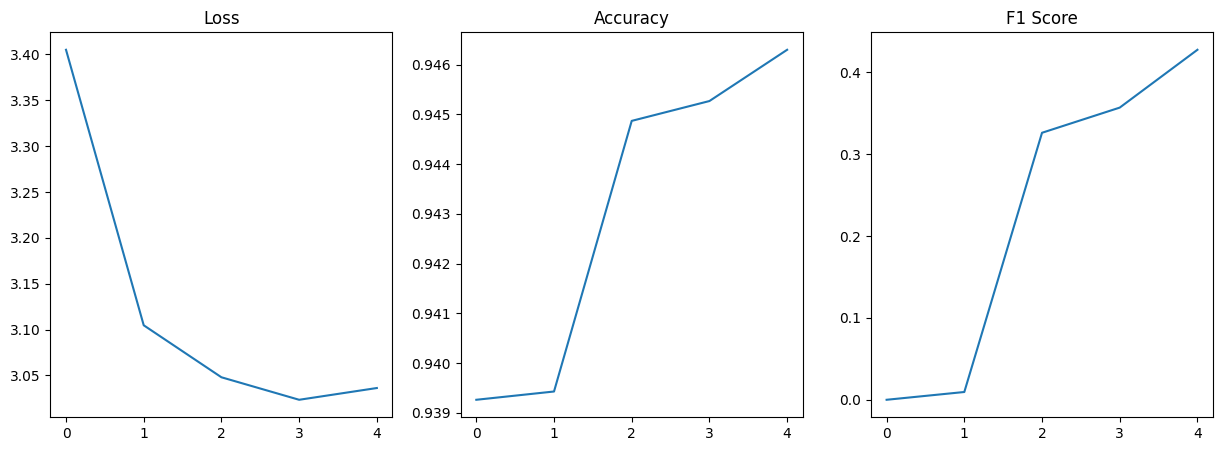

In [211]:
model = QuoraClassifier()
val_losses, val_accs, val_f1s = fit(model, train_dl, val_dl, 5)
vmetrics(val_losses, val_accs, val_f1s)

### Make predictions on example data


In [293]:
small_df = raw_df.sample(10)
small_df

,qid,question_text,target
1145533,e073643abed2d714c482,What is the best tonic for plants by organic way?,0
326983,40193825be746611df5b,Does the mouth have more bacteria and disease ...,0
71870,0e1689390f3fc937c13b,What should be my weight if I am 5'4 and 40 ye...,0
1003130,c4986a1ff835b5f9bbd7,Who would win a tag-team wrestling match betwe...,1
511349,642454afe3aa22446995,Actually I am a singing bowl manufacturer. How...,0
1170514,e562524b458feea41dd9,What thoughts do you have towards political co...,0
272866,356928980b48fcd51c31,Why do Muslims persecute other religions?,1
638200,7d00882b064e0ef54fbf,Will World War Three start?,0
941966,b89c954b0c2c54a53ac7,Is Jio unlimited at night for non prime users?,0
1190174,e93b7248c12f8a142432,How do other INTPs get out of cycles?,0


In [286]:
def predict_df(df):
    inputs = vectorizer.transform(df.question_text)
    outputs = model(torch.tensor(inputs.toarray(), dtype=torch.float32))
    probs = torch.sigmoid(outputs[:, 0])
    preds = (probs > 0.5).int()
    return preds

In [294]:
small_df.target.values

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [295]:
predict_df(small_df)

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=torch.int32)

## Generate Predictions for Test Data


In [312]:
def make_preds(dl):
    all_preds = np.array([])
    for batch in dl:
        inputs = batch[0]
        outputs = model(inputs)
        probs = torch.sigmoid(outputs[:, 0])
        preds = (probs > 0.5).int()
        all_preds = np.concatenate((all_preds, preds.cpu().numpy()))
    return all_preds

In [313]:
test_preds = make_preds(test_dl)

In [315]:
len(test_preds)

375806

In [321]:
# Convert test predictions from float to int
test_preds = test_preds.astype(int)
test_preds[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0])

## Submit Predictions to Kaggle

In [322]:
sub_df["prediction"] = test_preds
sub_df

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0


In [325]:
sub_df.prediction.value_counts()

prediction
0    362346
1     13460
Name: count, dtype: int64

In [323]:
# Save submission
sub_fname = "submission.csv"
sub_df.to_csv(DATA_DIR + "/" + sub_fname, index=False)

In [324]:
!head $DATA_DIR/$sub_fname

53515.14s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


qid,prediction
0000163e3ea7c7a74cd7,0
00002bd4fb5d505b9161,0
00007756b4a147d2b0b3,0
000086e4b7e1c7146103,0
0000c4c3fbe8785a3090,0
000101884c19f3515c1a,0
00010f62537781f44a47,0
00012afbd27452239059,0
00014894849d00ba98a9,0
